# 5 次元削減でデータを圧縮する

特徴部分空間(feature extraction)を作成する

- 主成分分析(PCA: PrincipalComponent Analysis)
- 線形判別分析(LDA: Linear Discriminant Analysis)
- カーネル主成分分析

## 5.1 主成分分析による教師なし次元削減

1. d次元のデータセットを標準化する
2. 標準化したデータセットの共分散行列(covariance matric)を作成する
3. 共分散行列を固有ベクトルと固有値に分解する
4. 最も大きいk個の固有値に対するk個の固有ベクトルを選択する
5. 上位k個の固有ベクトルから射影行列Wを作成する
6. 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する

### 5.1.1 共分散行列の固有対を求める

In [1]:
from IPython.core.display import display

import pandas as pd
# http://archive.ics.uci.edu/ml/datasets/Wine
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# 1. d次元のデータセットを標準化する

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
# 特徴量とクラスラベルを別々に抽出
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np
# 2. 共分散行列を作成
cov_mat = np.cov(X_train_std.T)
# 3. 固有値と固有ベクトルを計算
# linalg.eig関数は固有分解(eigendecomposition)を実行する関数
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([ 4.8923083 ,  2.46635032,  1.42809973,  1.01233462,  0.84906459,
        0.60181514,  0.52251546,  0.08414846,  0.33051429,  0.29595018,
        0.16831254,  0.21432212,  0.2399553 ])

'var_exp:'

[0.37329647723490678,
 0.18818926106599568,
 0.10896790724757797,
 0.077243894771248725,
 0.064785946018261806,
 0.045920138114781489,
 0.039869355976347082,
 0.025219142607261602,
 0.022581806817679684,
 0.018309244719526906,
 0.016353362655051468,
 0.012842705837492729,
 0.0064207569338683096]

'cum_var_exp:'

array([ 0.37329648,  0.56148574,  0.67045365,  0.74769754,  0.81248349,
        0.85840362,  0.89827298,  0.92349212,  0.94607393,  0.96438317,
        0.98073654,  0.99357924,  1.        ])

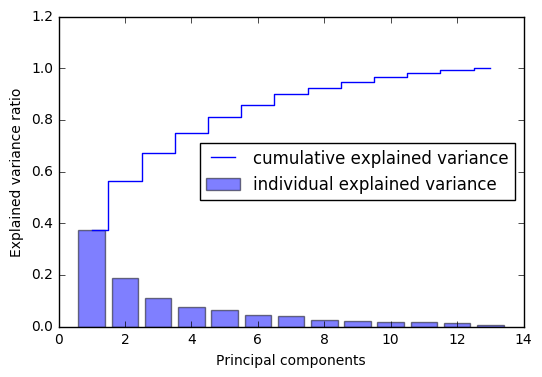

In [3]:
# 固有値を合計
tot = sum(eigen_vals)
# 分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
display("var_exp:", var_exp)
# 分散説明率の累積和を取得
cum_var_exp = np.cumsum(var_exp)
display("cum_var_exp:", cum_var_exp)

import matplotlib.pyplot as plt
# 分散説明率の棒グラフを作成
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
# 分散説明率の累積和の階段グラフを作成
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

### 5.1.2 特徴変換

In [4]:
# (固有値, 固有ベクトル)のタプルのリストを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# (固有値, 固有ベクトル)のタプルを大きいものから順に並び替え
eigen_pairs.sort(reverse=True)

In [5]:
# 4. 最も大きいk個の固有値に対するk個の固有ベクトルを選択する(ここでは k = 2 とする)
# 5. 上位k個の固有ベクトルから射影行列Wを作成する
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
display("Matrix W:", w)

'Matrix W:'

array([[ 0.14669811,  0.50417079],
       [-0.24224554,  0.24216889],
       [-0.02993442,  0.28698484],
       [-0.25519002, -0.06468718],
       [ 0.12079772,  0.22995385],
       [ 0.38934455,  0.09363991],
       [ 0.42326486,  0.01088622],
       [-0.30634956,  0.01870216],
       [ 0.30572219,  0.03040352],
       [-0.09869191,  0.54527081],
       [ 0.30032535, -0.27924322],
       [ 0.36821154, -0.174365  ],
       [ 0.29259713,  0.36315461]])

In [6]:
# x' = xW
display(X_train_std[0].dot(w))

# 6. 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する
# X' = XW
X_train_pca = X_train_std.dot(w)

array([ 2.59891628,  0.00484089])

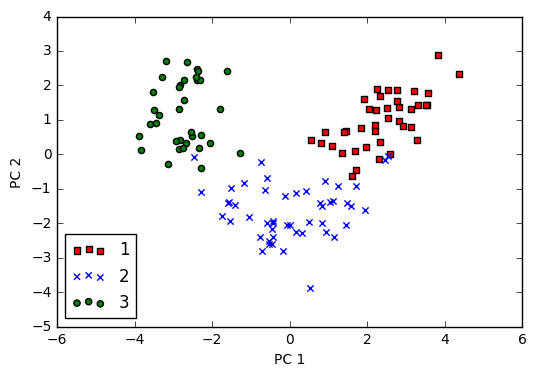

In [7]:
# 2次元の散布図としてプロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
# クラスラベル、点の色、点の種類の組み合わせからなるリストを生成してプロット
for label, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==label, 0], X_train_pca[y_train==label, 1], c=c, label=label, marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### 5.1.3 scikit-learn の主成分分析

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの用意
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    

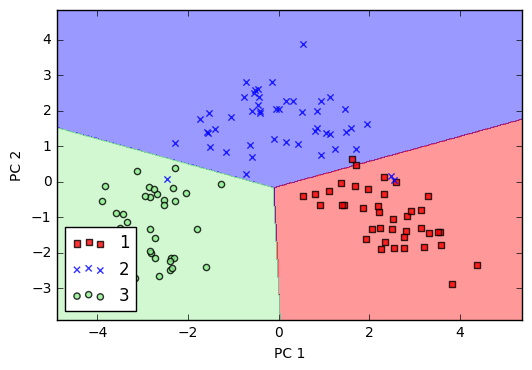

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# 主成分数を指定して、PCAのインスタンスを生成
pca = PCA(n_components=2)
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression()
# トレーニングデータやテストデータをPCAに適合させる
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# トレーニングデータをロジスティック回帰に適合させる
lr.fit(X_train_pca, y_train)
# 決定境界をプロット
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

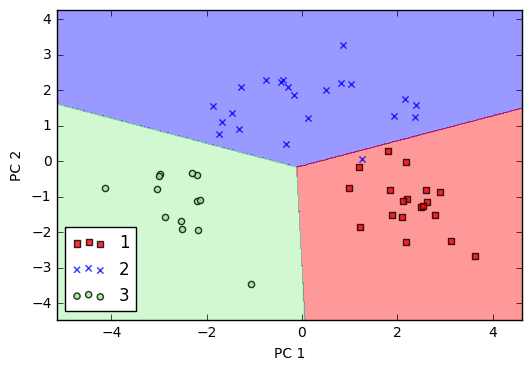

In [10]:
# 決定境界をプロット
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [11]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
# 分散説明率を計算
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])